In [1]:
from google.colab import auth
auth.authenticate_user()
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse
!mkdir bucket
!gcsfuse gcommand ./bucket

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  18657      0 --:--:-- --:--:-- --:--:-- 19205
OK
23 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 4,278 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 144618 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.30.0_amd64.deb ...
Unpacking gcsfuse (0.30.0) ...
Setting up gcsfuse (0.30.0) ...
Using mount point: /content/bucket
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PROJECT_PATH = '/content/drive/My Drive/Projects/Speech-Commands-Classification/'
MODELS_PATH = '/content/drive/My Drive/Projects/Speech-Commands-Classification/models/'
import sys
sys.path.append(PROJECT_PATH)
sys.path.append('/content/')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
pip install rootpath

     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 235kB 35.1MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
     |████████████████████████████████| 92kB 10.7MB/s 
     |████████████████████████████████| 4.9MB 43.3MB/s 
     |████████████████████████████████| 337kB 39.8MB/s 
  Created wheel for ordered-set: filename=ordered_set-4.0.2-py2.py3-none-any.whl size=8209 sha256=ccfec89786630a55716dba242eb9b5ebb8ea7adbe108fc2743415f7691c6b94d
  Stored in directory: /root/.cache/pip/wheels/e1/c6/9b/651d8a21d59b51a75ab9c070838f9231b8126421bc0569af47
Successfully built ordered-set
ERROR: pytest 3.6.4 has requirement pluggy<0.8,>=0.5, but you'll have pluggy 0.13.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is i

In [6]:
!unzip -qq /content/bucket/dataset.zip -d /content

In [7]:
import torch
from torch import optim
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt

from const import Consts
from data_handler.loaders import get_data_loaders
from model import LeNet, weight_init
from train import train, evaluation, test_model
from main import plot_graphs

In [8]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [ ]:
train_loader, valid_loader, test_loader = get_data_loaders('/content/dataset/')

model = LeNet(35)
optimizer = optim.Adam(model.parameters(), lr=Consts.lr)
loss_criterion = nn.NLLLoss()
model.apply(weight_init)
model.to(device)
train_loss = []
val_loss = []
val_acc = []
for epoch in range(Consts.epochs):
    t_loss = train(model, train_loader, optimizer, loss_criterion, device)
    v_loss, v_acc = evaluation(model, valid_loader, loss_criterion, device)
    torch.save(model.state_dict(), f'{MODELS_PATH}epoch-{epoch + 1}.pth')
    train_loss.append(t_loss)
    val_loss.append(v_loss)
    val_acc.append(v_acc)
    print(f'train loss in epoch {epoch + 1} is: {t_loss}')
    print(f'validation loss in epoch {epoch + 1} is: {v_loss}')
    print(f'validation accuracy in epoch {epoch + 1} is: {v_acc}')

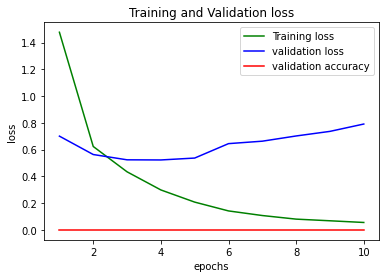

test accuracy is: 0.013630168105406633


In [34]:
plot_graphs(train_loss, val_loss, val_acc)
test_model(model, test_loader, loss_criterion, val_loss, device, MODELS_PATH)

# No need

In [ ]:
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)
val_acc = np.array(val_acc)
np.save(f'{MODELS_PATH}train_loss.npy', train_loss)
np.save(f'{MODELS_PATH}vall_loss.npy', val_loss)
np.save(f'{MODELS_PATH}vall_acc.npy', val_acc)

In [9]:
train_loader, valid_loader, test_loader = get_data_loaders('/content/dataset/')
model = LeNet(35)
optimizer = optim.Adam(model.parameters(), lr=Consts.lr)
loss_criterion = nn.NLLLoss()
model.apply(weight_init)
model.to(device)

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=55936, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=35, bias=True)
  (activation): ReLU()
)

In [11]:
train_loss = np.load(f'{MODELS_PATH}train_loss.npy')
val_loss = np.load(f'{MODELS_PATH}vall_loss.npy')
val_acc = np.load(f'{MODELS_PATH}vall_acc.npy')